In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
# Set some constant parameters
IMAGE_SHAPE = (224, 224)
EPOCHS = 15
BATCH_SIZE = 32

# Specify paths to datasets
TRAIN_DATA_DIR = '/content/drive/MyDrive/10 big cats of the wild kaggle dataset/train'
TEST_DATA_DIR = '/content/drive/MyDrive/10 big cats of the wild kaggle dataset/test'
VALID_DATA_DIR = '/content/drive/MyDrive/10 big cats of the wild kaggle dataset/valid'

In [ ]:
# Load the data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical',
    seed=1234,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

valid_generator = datagen.flow_from_directory(
    directory=VALID_DATA_DIR,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical',
    seed=1234,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

test_generator = datagen.flow_from_directory(
    directory=TEST_DATA_DIR,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


Image dimensions: (224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

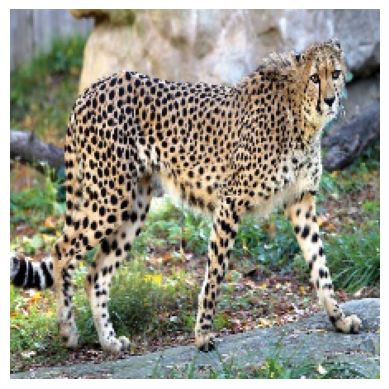

In [ ]:
# Checking one example
example = '/content/drive/MyDrive/10 big cats of the wild kaggle dataset/train/CHEETAH/001.jpg'

image = mpimg.imread(example)

# Print out the image dimensions
print('Image dimensions:', image.shape)
plt.imshow(image)
plt.axis("off")

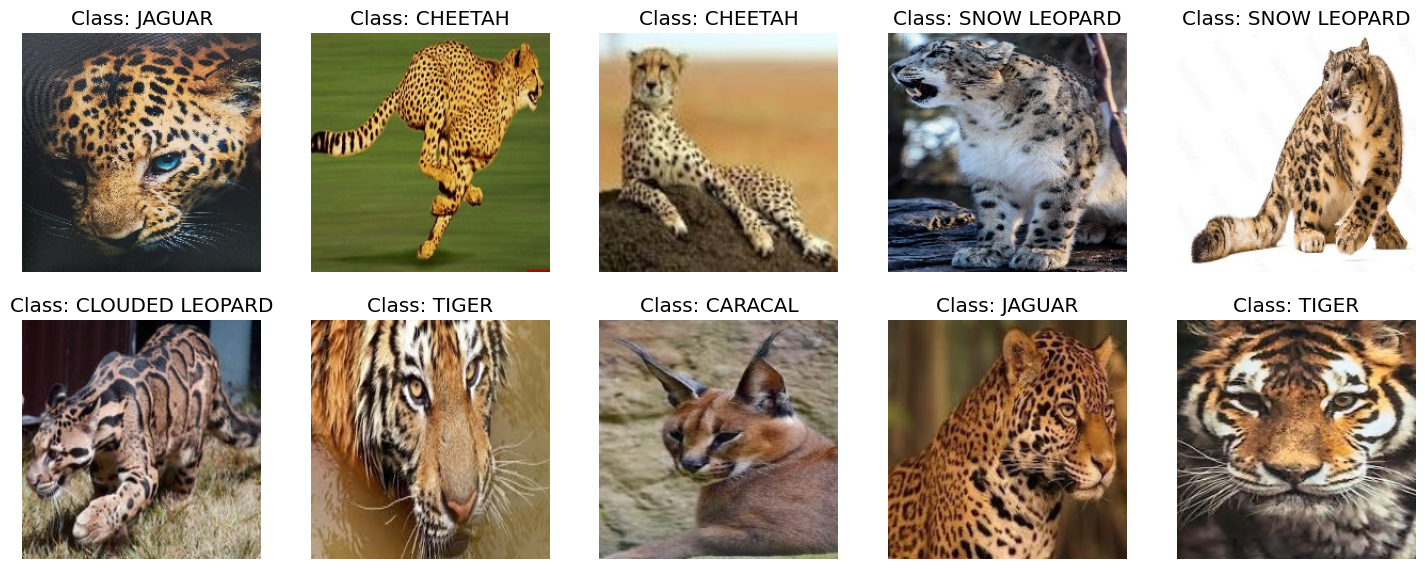

In [ ]:
# Collect the labels
labels = [l for l in train_generator.class_indices]
# Take the next batch out of train_generator
samples = next(train_generator)
# Store info on pixels of each image in images
images = samples[0]
# Store info on the class in titles
titles = samples[1]

# Set figure size
plt.figure(figsize=(18,18))

# Create subplots
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")


 Train dataset

         class_name  class_index  instances  class_percent
0  AFRICAN LEOPARD            0        236       0.100898
1          CARACAL            1        236       0.100898
2          CHEETAH            2        235       0.100470
3  CLOUDED LEOPARD            3        229       0.097905
4           JAGUAR            4        238       0.101753
5            LIONS            5        228       0.097478
6           OCELOT            6        233       0.099615
7             PUMA            7        236       0.100898
8     SNOW LEOPARD            8        231       0.098760
9            TIGER            9        237       0.101325

 Total number of instances:2339


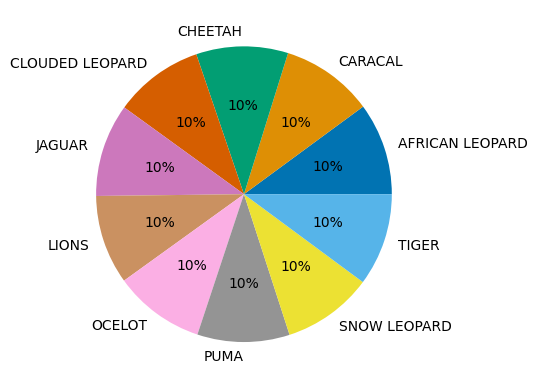


 Validation dataset

         class_name  class_index  instances  class_percent
0  AFRICAN LEOPARD            0          5            0.1
1          CARACAL            1          5            0.1
2          CHEETAH            2          5            0.1
3  CLOUDED LEOPARD            3          5            0.1
4           JAGUAR            4          5            0.1
5            LIONS            5          5            0.1
6           OCELOT            6          5            0.1
7             PUMA            7          5            0.1
8     SNOW LEOPARD            8          5            0.1
9            TIGER            9          5            0.1

 Total number of instances:50


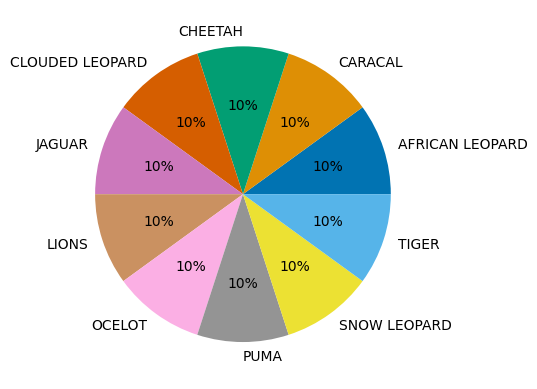


 Test dataset

         class_name  class_index  instances  class_percent
0  AFRICAN LEOPARD            0          5            0.1
1          CARACAL            1          5            0.1
2          CHEETAH            2          5            0.1
3  CLOUDED LEOPARD            3          5            0.1
4           JAGUAR            4          5            0.1
5            LIONS            5          5            0.1
6           OCELOT            6          5            0.1
7             PUMA            7          5            0.1
8     SNOW LEOPARD            8          5            0.1
9            TIGER            9          5            0.1

 Total number of instances:50


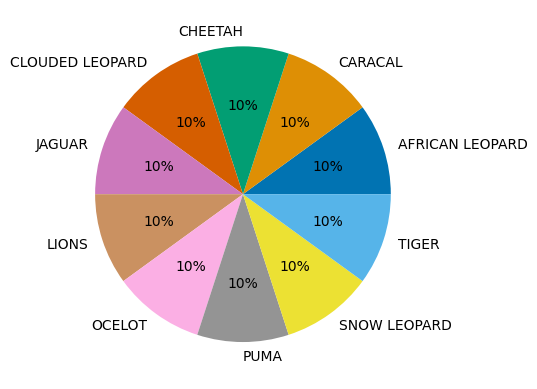

In [ ]:
# Check for potential class imbalance
names = ['Train dataset', 'Validation dataset', 'Test dataset']

for gen, name in zip([train_generator, valid_generator, test_generator], names):
    labels = [l for l in gen.class_indices]
    unique, counts = np.unique(gen.classes, return_counts=True)
    df = pd.DataFrame(data={'class_name': labels, 'class_index' : unique,'instances':counts})
    total_instances = sum(df['instances'])
    df['class_percent'] = df['instances'] / total_instances
    
    print("\n", name)
    print("\n", df)
    print("\n", f"Total number of instances:{total_instances}")

    palette_color = sns.color_palette("colorblind")

    # Plotting data on chart
    plt.pie(x=df['class_percent'], labels=df['class_name'], autopct='%.0f%%', colors=palette_color)
  
    # Displaying chart
    plt.show()


In [ ]:
breed_counts = {}

for root, dirs, files in os.walk('/content/drive/MyDrive/10 big cats of the wild kaggle dataset'):
    for file in files:
        if file.endswith('.jpg'):
            breed = os.path.basename(os.path.dirname(root))
            if breed not in breed_counts:
                breed_counts[breed] = 0
            breed_counts[breed] += 1

print("Breed distribution:", breed_counts)


Breed distribution: {'test': 50, 'valid': 50, 'train': 2339}


In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/10 big cats of the wild kaggle dataset/EfficientNetB0-10-(224 X 224)-100.00.h5'
model= keras.models.load_model(model_path, custom_objects={'F1_score':'F1_score'}) 

In [ ]:
!pip install flask-ngrok


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/classify_image', methods=['POST'])
def classify_image():
    # Get the image from the request
    image_file = request.files['image']

    # Preprocess the image
    # ...

    # Make a prediction with the model
    prediction = model.predict(preprocessed_image)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)

    # Return the result as JSON
    return jsonify({'class': predicted_class})


In [ ]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def index():
    return 'Hello, world!'

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
from flask_ngrok import run_with_ngrok

run_with_ngrok(app)


In [ ]:
!python app.py


python3: can't open file '/content/app.py': [Errno 2] No such file or directory
